# House Prices: Advanced Regression Techniques
### Predict sales prices and practice feature engineering, RFs, and gradient boosting
this a frame work to serve as the skeleton for my practice while i comment oneach line of code and edit to better suit me so  i i can thoroughly understand the reasoning.


### packages used
this id a regression problem 

In [130]:

import numpy as np # linear algebra
import pandas as pd # data processing, 

from datetime import datetime
from scipy.stats import skew  # for some statistics why?
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor # these are high powered regression models i know nothing about
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
#print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

### Load data

In [131]:
test = pd.read_csv('.../input/test.csv')
train = pd.read_csv('..../input/train.csv')

In [132]:
print ("Train: ",train.shape[0],"sales/rows, and ",train.shape[1],"features/columns")
print ("Test: ",test.shape[0],"sales/rows, and ",test.shape[1],"features/columns")

Train:  1460 sales/rows, and  81 features/columns
Test:  1459 sales/rows, and  80 features/columns


this will be way more difficult it has **81** columns, the column misssing in the test data must be the sales price that we are tring to predict

In [133]:
train.head() #overview of data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


quick survey of the the data it can be seen that the data can be divided into three possible segments: building, space or location. When we say 'building', we mean a variable that relates to the physical characteristics of the building (e.g. 'OverallQual'). When we say 'space', it means mean a variable that reports size properties of the house (e.g. 'Lot area'). Fi 'location', we mean a variable that gives information about the place where the house is located (e.g. 'MBZoning')

In [134]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Explorative Data Analysis

This involves viewing the data and breaking it into more managevle sections before checking out Identification of the variables' type. There are two possible values for this field: 'numerical' (quantitative) or 'categorical'(qaulitative). 

In [135]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object' ] #to find out if is numerical ie float or integer
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [136]:
 print(quantitative, end='')

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

In [137]:
print(qualitative, end='')

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

There are 1460 rows of training data and 1460 of test data. Total number of attributes/columns equals 81, of which 36 is quantitative, 43 categorical + Id and SalePrice.

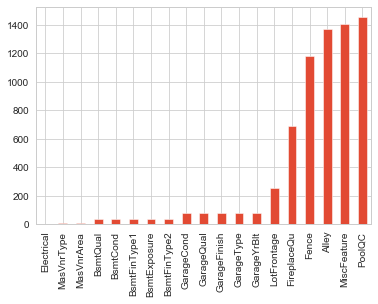

In [138]:
sns.set_style("whitegrid") #white backgroynd 
#the ones with missing values
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
#or you can don it the way you dit it in titanic by percentages

In [139]:
# study of actual missing data
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)[train.isnull().sum().sort_values(ascending = False) != 0]
    #sort by ascending number missing values
    percentageA = df.isnull().sum()/train.isnull().count()*100   #converts total to percentage
    percentageB = round((percentageA).sort_values(ascending=False),2)    #approximates percentage and sorts my number ascending order
    return pd.concat([total, percentageB], axis=1, keys= ['total','%'])     #creates a table

missing_data(train).head(19)

,total,%
PoolQC,1453.0,99.52
MiscFeature,1406.0,96.30
Alley,1369.0,93.77
Fence,1179.0,80.75
FireplaceQu,690.0,47.26
LotFrontage,259.0,17.74
GarageCond,81.0,5.55
GarageType,81.0,5.55
GarageYrBlt,81.0,5.55
GarageFinish,81.0,5.55


19 attributes have missing values, 8 over 50% of all data and two at 100%. Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement. (for now i am assuming the test 

##  finding relationships

the end goal is to determine the sales price so it importance to plot sales prices againsts the features but seeing as it has 81 features, the features cannot be taken on a case by case basis like the titanic data. it is important toselect corrolation methods that can be used to streamline the process. Using a correlation matrix, we can identify the exploratory variables which are strongly correlated with SalePrice (target variable). These insights may shed light on which variables help predict the SalePrice.

Additionally, the correlation between pairs of variables will identifty any multicolinear factors which may distort the model.

first we need to find the the out the distribution of the outcome from the training data
 Let's create a histogram to see if the target variable is Normally distributed. If we want to create any linear model, it is essential that the features are normally distributed. This is one of the assumptions of multiple linear regression?

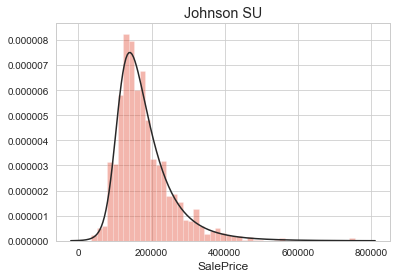

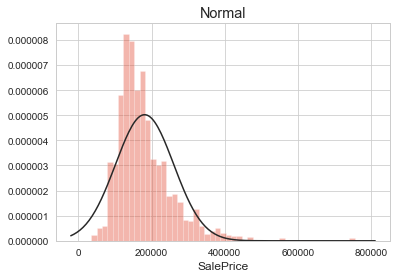

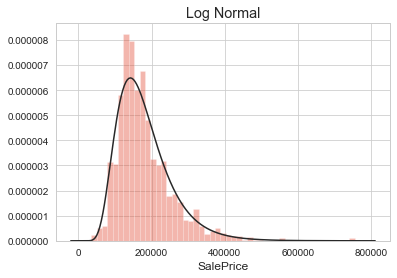

In [140]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU') #johnson SU distribution
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm) #normal distribution
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm) #log-normal distribution
#the purpose of these graphs is to check if the target variable aligns with any of these common distributions

In [141]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any()) #code to supplement the graph

False


It is apparent that SalePrice does **NOT** follow normal distribution, so before performing regression it has to be **transformed**. While log transformation does pretty good job, best fit is unbounded Johnson distribution. we can clearly see that that the the distribution is rightly/positively skewed.
Positive Skewness(similar to our target variable distribution) means the tail on the right side of the distribution is longer and fatter.
In positive Skewness the mean and median will be greater than the mode similar to this dataset. Which means more houses were sold by less than the average price.to accurately measure the level of skewness and the kurtosis 

In [142]:
#skewness and kurtosis
print("Skewness: " + str(train['SalePrice'].skew()))
print("Kurtosis: " + str(train['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


Also none of quantitative variables has normal distribution so these should be transformed as well.

other studies of the targetvariable

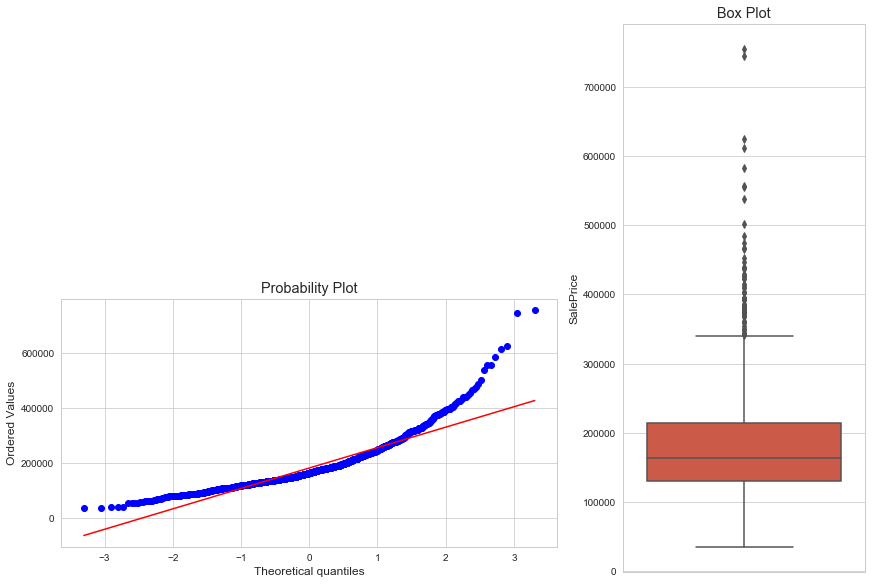

In [143]:
# Creating a customized chart. and giving in figsize and everything. 
fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)
   
    # customizing the QQ_plot. 
ax1 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
ax1.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
stats.probplot(train.loc[:,'SalePrice'], plot = ax1)

    ## Customizing the Box Plot. 
ax2 = fig.add_subplot(grid[:, 2])
    ## Set title. 
ax2.set_title('Box Plot')
    ## Plotting the box plot. 
sns.boxplot(train.loc[:,'SalePrice'], orient='v', ax = ax2 );
    #this explains how the histogram is built


these two plots basicqally show that the target variable possesses outliers

In [144]:
## Getting the correlation of all the features with target variable. 
#with pd.option_context('display.max_rows', 1000):#kepping this anytime iwant to sispaly all the values
print((train.corr()**2)["SalePrice"].sort_values(ascending=False)[1:5]) 

OverallQual    0.625652
GrLivArea      0.502149
GarageCars     0.410124
GarageArea     0.388667
Name: SalePrice, dtype: float64


#default is pearson but it only focuses on linear correlation and from the qq plot we can see that there is some discrepancy from a purly linear relationship **Spearman correlation** is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

In [145]:
spr = (train.corr('spearman',min_periods=1)**2)["SalePrice"].sort_values(ascending = False)[1:10]
print(spr)


OverallQual    0.655822
GrLivArea      0.534814
GarageCars     0.477082
YearBuilt      0.425993
GarageArea     0.421692
FullBath       0.404441
TotalBsmtSF    0.363278
GarageYrBlt    0.352585
1stFlrSF       0.331094
Name: SalePrice, dtype: float64


we can see that the it generally correlates in the same order but with a strongler level of corellation using the spearman method

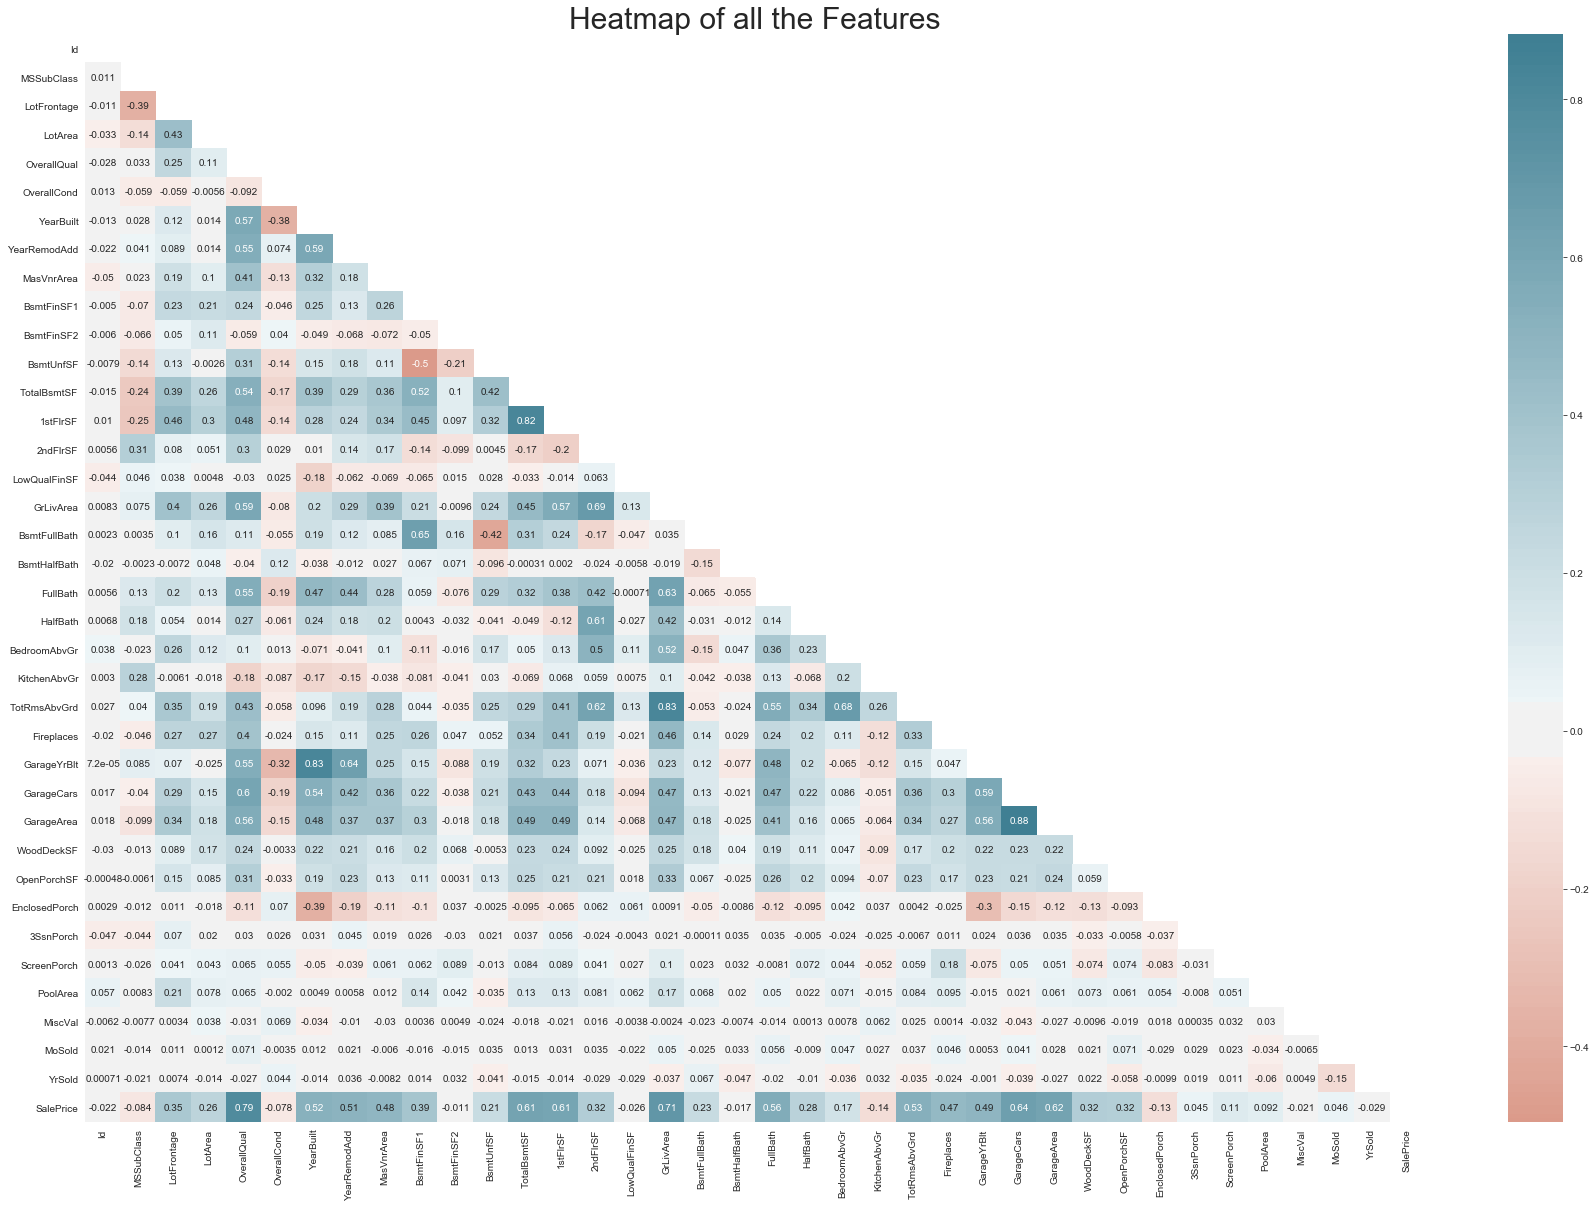

In [146]:
## Plot fig sizing. 
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           )
           
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

Observation.
As we can see, some predictor variables can be linearly predicted from the others with a substancial degree of acurracy thus  multicollinearity still exists in various features i.e high corellation, however there is no perfect colinearity between any variables thus the value can still be kept because we are trying many models and not justthe multiple regression models but i will attempt to drop it to test the multiple regression model
There is ;
* 0.83 or **83%** correlation between **GarageYrBlt** and **YearBuilt**. it makes sense that most garages will be built at the same time as the house
* 88% correlation between GarageCars and GarageArea
* 83% correlation between TotRmsAbvGrd ** and **GrLivArea.


# visualising outliers

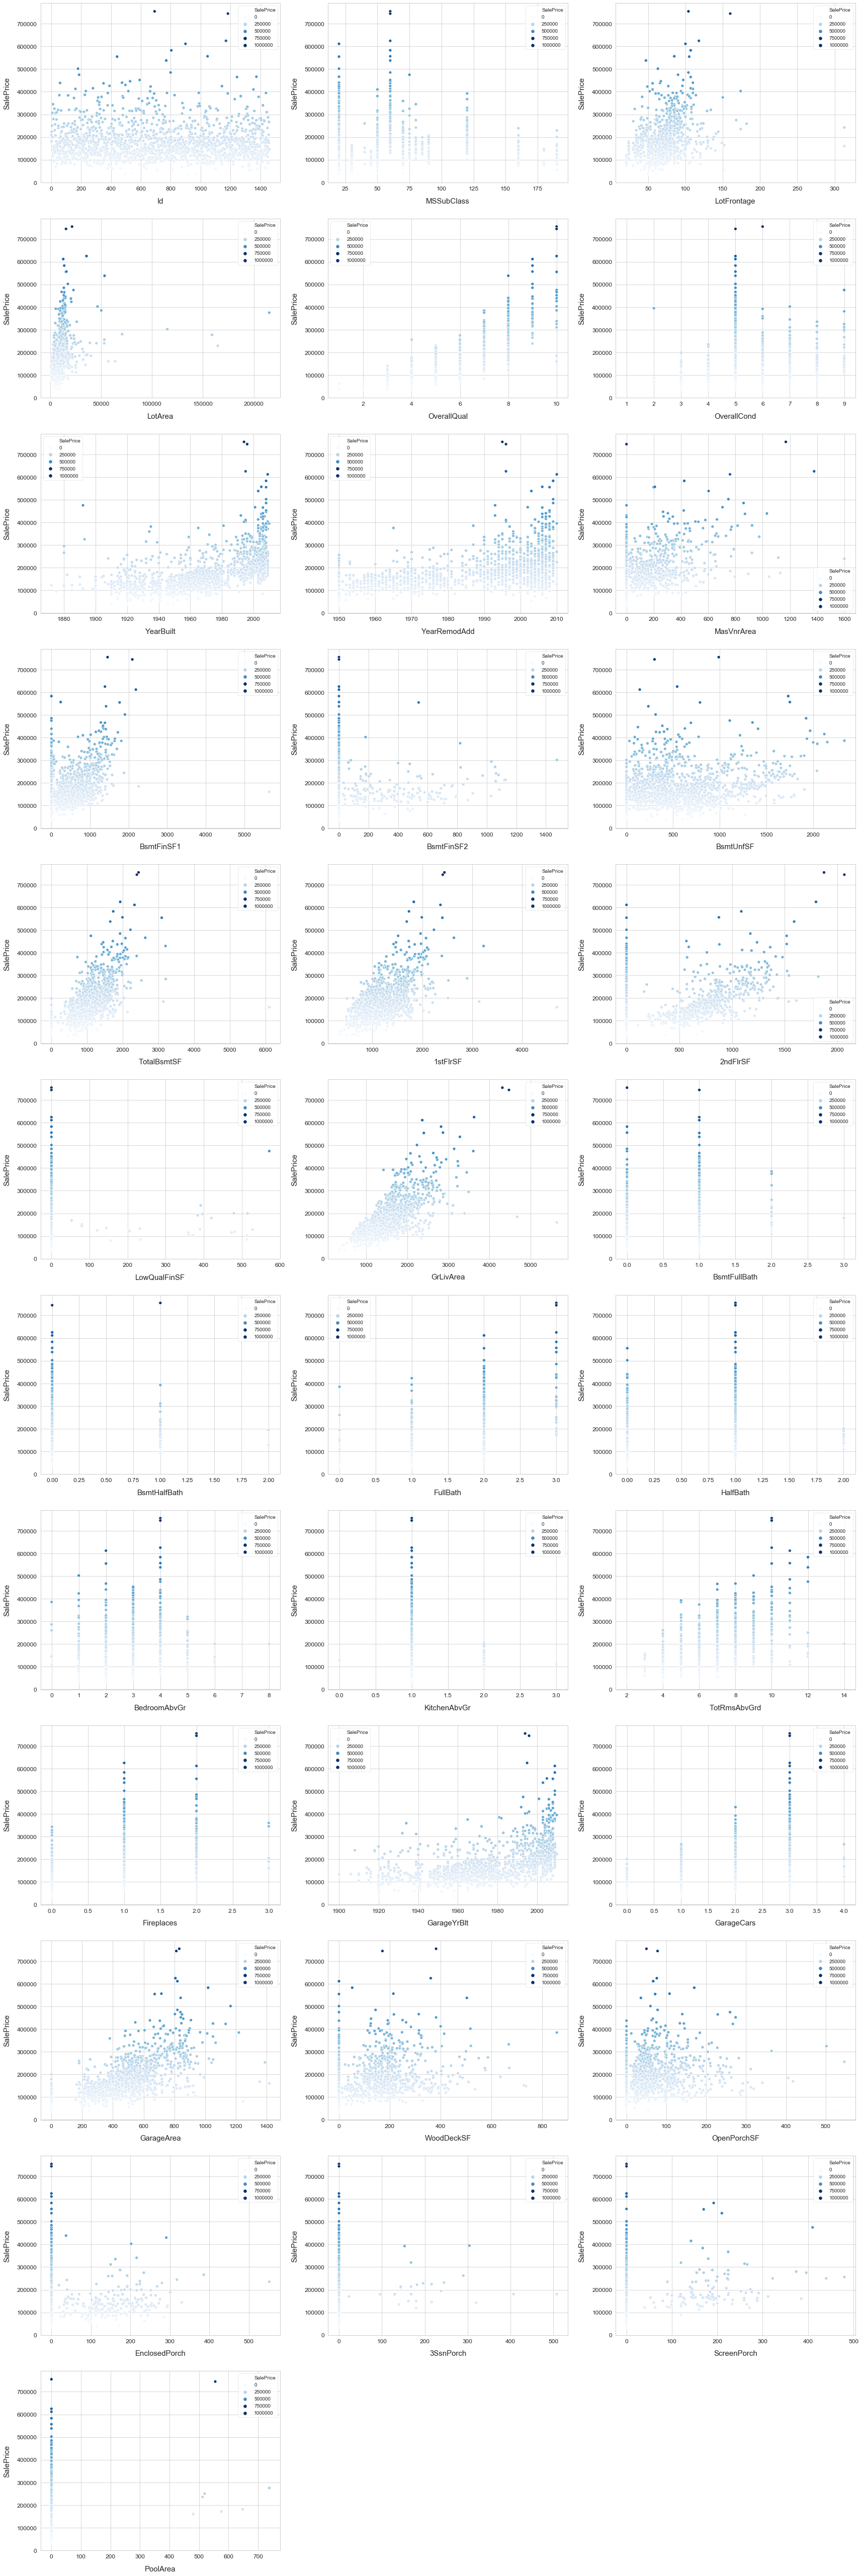

In [147]:
numeric = []
for i in train.columns:
    if train[i].dtype != object:
        numeric.append(i)
        
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 7)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

**OBSERVATIONS**
* 	Id isn’t showing ang trend so will eventually be dropped
*	There is a general idea that the higher the lot frontage the better the sales price but there are some outliers that are selling under 300,000, with lot sizes over 300, overall condition at 2 has a rather high price of over 400,000
*	Same thing for area
*	For overall quality there is a notable outlier than sold for greater than 300,000 when there, howeverthe quality being unde 300,000 may be due to the general size of the house
*	There don’t seem to be solid trends in overallcondition
*	It is trending up for newer houses to be more expensive but there are expensive old houses there is another column for remodeled after these two features will be combined later on in tha analysis plus older houses might be quite large increasing their prices
*	The garagearea and cars follow an obvious trend of larger is moreexpensive with obvious outliers being greater than 1200sf yet with prices being lower than 300,000, i.e more than four cars yet lower than 300k, i will use garage cars because it has a higher corellation than garage area,and the two are highly correlated
*	Decks and porches of various sizes have various price ranges with no particular
* it is weird that a builing with no full bath cost almost 400,000


# Cleaning and modelling

### Data processing

In [148]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

## removing outliers and normalising the sale price
to pick my outliers i am using the values that show the highest correlattion with the sales price the sales price

In [149]:
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

### Features

In [150]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [151]:
features.shape

(2916, 79)

# filling missing data and feature engineering

In [152]:
train['Electrical'].describe() #checking all columns with missing will help us fill them, check their content and fill it up with
# the most common value and also interpret the clank as none in the case of pool, have the dataset open in excel to view

count      1456
unique        5
top       SBrkr
freq       1331
Name: Electrical, dtype: object

In [153]:
features['MSSubClass'] = features['MSSubClass'].apply(str) #iam doing this because these are numerical data that act like strings
features['YrSold'] = features['YrSold'].astype(str)#i.ethey do nothing for the model like subclass,monthsold etc
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') #typ is the most common
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])


In [154]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


always google the meanings or  i.e (search for domain knowledge) of each column to better aid in interpreting it for example
we fill the columns garragearea and garage cares as zero because we will assume there is no garage and these values are numerical in nature
since there is no garage things like garage finish and and garagecondition, same goes for basement(bmst) and fireplace

In [155]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    features[i] = features[i].fillna('None')


In [156]:
## In the following features the null values are related to the above 
#if there are no garages then the garage are willbe zero, so we replace them with "0"
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    features[i] = features[i].fillna(0)
    

In [157]:
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
#this is because we are dealling with numerical values
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.median()))
## Replaced all missing values in mszone by imputing the modal value of each mszone this itis a categorical data
#it identifies the type of dwelling that is upforsale thus the most common will be a fitting
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [158]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


In [159]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

#code to change all object based missing features I may have missed to none
 

#code to change all numeric based feaures you missed to 0


In [160]:
numerics = []
for i in features.columns:
    if features[i].dtype != object:
        numerics.append(i)
features.update(features[numerics].fillna((0)))

In [161]:
features.isnull().sum().sum()

0

all missing data successfully removed

## fixing Skewness

In [162]:
numeric_dtypes = features.dtypes[features.dtypes != "object"].index
skew_features = features[numeric_dtypes].apply(lambda x: skew(x)).sort_values(ascending=False)  
#this checks the features skewness values

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
## Fixing Skewed features using boxcox transformation.
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

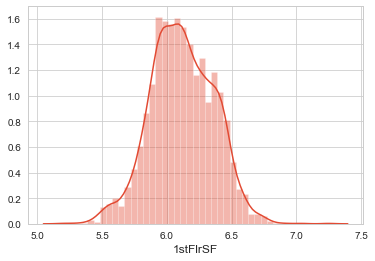

In [163]:
sns.distplot(features['1stFlrSF']); #to check if you have fixed skewness, using a quantitative variable, 
#it looks normally distributed, it doesnt work for everything this is just to improve our chances of running more models

# removing redundant features and creating new features

In [164]:
train['Street'].describe() #this helps us check for how similar a column is so I can drop it especially for categorical data

count     1457
unique       2
top       Pave
freq      1451
Name: Street, dtype: object

In [165]:
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
#tomanny people dont have them like pools, or they are mostly the same
#NEW FEATURES
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd'] 
#remodelling a house makes it as good as new

features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
#total sqr1

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


In [166]:
# more new features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# the goal here is to covert numertical data that has relationships with categorical data into yes/no,1/0 to create new features

## adding logarithimic features and encoding the qualitaive data

In [167]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

features = logs(features, log_features)

In [168]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
features = squares(features, squared_features)

In [169]:
features.shape

(2916, 124)

In [170]:
features.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq
0,60,RL,18.133316,14.054267,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.990329,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.438232,Gd,TA,PConc,Gd,TA,No,GLQ,143.919993,Unf,0.0,30.010263,422.114915,GasA,Ex,Y,SBrkr,5.929134,1026.392095,0.0,8.339938,0.993263,0.000000,2,1.068921,3,0.750955,Gd,2.262646,Typ,0.0000,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.000000,12.071121,0.00000,0.0,0.0,0.0,None,None,0.0,2,2008,WD,Normal,4006,1454.436145,1176.241222,3.527724,12.071121,0,1,1,1,0,2.951954,2.712325,3.017896,4.976251,0.00995,3.434641,6.047667,1.937177,6.934789,0.00995,2.235370,0.694777,0.009950,1.101940,0.731849,1.388791,0.565856,1.185599,0.009950,1.101940,6.308117,0.009950,2.571170,0.009950,0.00995,0.00995,0.00995,0.00995,7.602905,7.283068,4012009,8.714030,36.574282,3.752655,48.091294,4.996878,1.214272,39.792336
1,20,RL,20.660026,14.347273,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,5.997759,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,181.454629,Unf,0.0,44.168161,593.327286,GasA,Ex,Y,SBrkr,6.224030,0.000000,0.0,7.962253,0.000000,0.710938,2,0.000000,3,0.750955,TA,1.997107,Typ,0.9033,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,56.101588,0.000000,0.00000,0.0,0.0,0.0,None,None,0.0,5,2007,WD,Normal,3952,599.551316,187.678659,2.355469,56.101588,0,0,1,1,1,3.075930,2.731589,0.009950,5.206556,0.00995,3.810614,6.387447,1.978796,0.009950,0.00995,2.194137,0.009950,0.542869,1.101940,0.009950,1.388791,0.565856,1.100978,0.648829,1.101940,6.133420,4.045007,0.009950,0.009950,0.00995,0.00995,0.00995,0.00995,7.589341,6.397865,3904576,9.461345,40.799479,3.915635,0.000099,4.814236,1.214272,37.618838
2,60,RL,18.656314,14.716281,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.990329,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.773263,Gd,TA,PConc,Gd,TA,Mn,GLQ,110.299812,Unf,0.0,56.942678,449.676701,GasA,Ex,Y,SBrkr,5.984243,1041.273704,0.0,8.394287,0.993263,0.000000,2,1.068921,3,0.750955,Gd,1.997107,Typ,0.9033,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.000000,9.894344,0.00000,0.0,0.0,0.0,None,None,0.0,9,2008,WD,Normal,4003,1496.934648,1157.557759,3.527724,9.894344,0,1,1,1,1,2.978907,2.755333,2.932966,4.712317,0.00995,4.059627,6.110772,1.945087,6.949169,0.00995,2.241166,0.694777,0.009950,1.101940,0.731849,1.388791,0.565856,1.100978,0.648829,1.101940,6.411835,0.009950,2.389161,0.009950,0.00995,0.00995,0.00995,0.00995,7.602406,7.311849,4008004,8.873888,37.341540,3.783365,48.290956,5.022824

## get dummy variables
it is important to get dummy variables in order to obtain a single regression equation to represent multiple groups

In [71]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2466, 369)

In [72]:
#for i in final_features.columns:
    #print (final_features[i].dtype)
    #run to check the results of hot encoding the data

In [73]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape
final_features = final_features.loc[:,~final_features.columns.duplicated()]

In [74]:
pd.set_option('display.max_columns',500)
X.head


<bound method NDFrame.head of       LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
0       17.090977  12.149690            7     3.787144       2003   
1       19.403102  12.374917            6     5.611703       1976   
2       17.570371  12.657396            7     3.787144       2001   
3       16.270360  12.365665            7     3.787144       1915   
4       19.987286  13.084914            8     3.787144       2000   
...           ...        ...          ...          ...        ...   
1002    19.106304  12.311467            8     3.787144       2008   
1003    11.624407  10.723326            5     3.787144       2005   
1004    16.601996  11.940790            7     3.787144       2004   
1005    16.601996  12.035374            6     3.787144       1999   
1006    20.131449  12.941510            6     4.416164       1978   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2   BsmtUnfSF  \
0             2003   20.775748  153.844218    0.000000   28.352988   
1

there will be no more modifications to the dataset thus it is important to set the values X, Y and Xsub taht will be used in our models, iloc the sets the columns of dataset to an index fron zero or y  to the len

In [75]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [76]:
X.shape, y.shape, X_sub.shape

((1007, 352), (1007,), (1459, 352))

In [77]:
#scoring uthe regression scores
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [78]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [79]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [80]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

In [81]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=7000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [82]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)


In [83]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

Get cross validation scores for each mode

In [55]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ridge: 0.1093 (0.0127)


In [56]:
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LASSO: 0.1077 (0.0124)



In [57]:
score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

elastic net: 0.1078 (0.0124)



In [58]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

SVR: 0.1095 (0.0127)



In [59]:
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

lightgbm: 0.1153 (0.0145)



In [60]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

gbr: 0.1150 (0.0131)



In [61]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[10:23:05] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:36] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:07] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:34] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:59] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:26:24] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:26:49] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: re

In [62]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[11:02:21] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:46] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:09] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:32] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:59] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:43] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:45] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regre

# Blending Models

In [66]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [67]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.0582803081576341


In [ ]:
import csv
with open('newsubmission','wb')

In [74]:
print('Predict submission')
submission = pd.read_csv(".....input/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

Predict submission


# Submission

In [77]:
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("newsubmission.csv", index=False)

In [78]:
submission.head()

,Id,SalePrice
0,1461,123930.0
1,1462,161694.0
2,1463,185914.0
3,1464,199867.0
4,1465,188235.0
